# clearmap2_demo_smartspim-aligncells
In this notebook we'll go through how to run the ClearMap2 cell detection on chunked up "blocks" of an entire SmartSPIM 3.6x volume. 

In the first part of the notebook we will just run the cell detection on two blocks, merge them together and save them as a cells.npy file. 

At the end, we'll go through how to do this for all of the blocks using parallelization on a desktop computer, i.e. not the cluster. Running this on the cluster is the end goal, but it's in development and not covered in this notebook.

# General imports

In [1]:
import os,sys, glob, shutil, pickle
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import SimpleITK as sitk
%matplotlib inline

In [2]:
# this line is so the modules in the next cell get imported. They live in this path.
# Change this to where you cloned ClearMap2 - if running on your PNI desktop, use the local path, not the jukebox path
sys.path.append('/jukebox/wang/ahoag/ClearMap2') 

## Clearmap specific imports

In [3]:
import ClearMap.IO.Workspace as wsp
import ClearMap.IO.IO as io
import ClearMap.ParallelProcessing.BlockProcessing as bp
import ClearMap.ImageProcessing.Experts.Cells as cells
import ClearMap.Settings as settings
import ClearMap.Alignment.Resampling as res
import ClearMap.Alignment.Elastix as elx   
import ClearMap.Alignment.Annotation as ano

Elastix sucessfully initialized from path: /jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build


## If necessary, link the corrected z planes to a new folder and in the process rename them to Z0000.tif, Z0001.tif, ...
Uncomment the lines below and run (changing paths as necessary) if you still need to do this

In [ ]:
# symlink files to a new directory with filenames Z0000.tif, Z0001.tif, etc...
# Change the dst_dir to where you want these z planes linked 
# src_dir = os.path.join('/jukebox/LightSheetData/lightserv/cz15',
#                        'zimmerman_01/zimmerman_01-001/imaging_request_1',
#                        'rawdata/resolution_3.6x/Ex_488_Em_0/corrected')
# dst_dir = '/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/ch488_renamed/corrected' 
# src_files = sorted(glob.glob(src_dir + '/*tif'))
# for ii,src in enumerate(src_files):
# #     print(src)
#     dst_basename = 'Z' + f'{ii}'.zfill(4) + '.tif'
#     dst = os.path.join(dst_dir,dst_basename)
#     os.symlink(src,dst)
    
    

# Set up the workspace


In [4]:
directory = os.path.join('/jukebox/wang/ahoag/test_clearmap2/output',
             'cz15/zimmerman_01_smartspim/zimmerman_01-001',
             'imaging_request_1/output')

expression_raw      = 'ch647_renamed/corrected/Z<Z,4>.tif'    
expression_auto     = 'ch488_renamed/corrected/Z<Z,4>.tif'

ws = wsp.Workspace('CellMap', directory=directory);
ws.update(raw=expression_raw)
ws.update(autofluorescence=expression_auto)
resources_directory = settings.resources_path
ws.debug=False
ws.info()

Workspace[CellMap]{/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output}
              raw: ch647_renamed/corrected/Z<Z,4>.tif {3589 files, ('Z',): (0,) -> (3588,)}
 autofluorescence: ch488_renamed/corrected/Z<Z,4>.tif {3586 files, ('Z',): (0,) -> (3585,)}
         stitched: stitched.npy
           layout: no file
       background: no file
        resampled: resampled.tif
resampled_to_auto: no file
auto_to_reference: no file
            cells: cells_raw.npy
                   cells_transformed_to_atlas.npy
                   cells_transformed_to_atlas_attempt1.npy
                   cells_transformed_to_atlas_attempt2.npy
          density: no file



## Verify that the raw data files were corrected read in.
The plot below should show a brain slice and should not be an empty image!

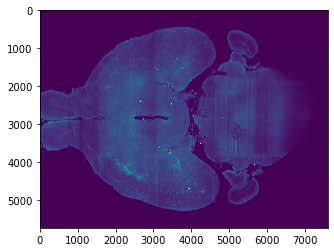

In [5]:
fig=plt.figure()
ax=fig.add_subplot()
z_plane = ws.source('raw')[:,:,2500]
ax.imshow(z_plane,vmin=0,vmax=200)

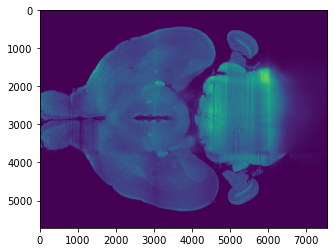

In [6]:
# Now check autofluoresence channel
fig=plt.figure()
ax=fig.add_subplot()
z_plane = ws.source('autofluorescence')[:,:,2500]
ax.imshow(z_plane,vmin=0,vmax=1000)

## If you haven't already, created the "stitched" volume -- this just puts the whole brain into a single stitched.npy file
This takes a while to run! ~ 20 mins for me.
If necessary, uncomment the lines below and then run the cell once. 

In [ ]:
# source = ws.source('raw');
# sink   = ws.filename('stitched')
# io.convert(source, sink, verbose=True) # creates a file called "stitched.npy"

# Resampling - raw data

In [31]:
resample_parameter = {
    "source_resolution" : (1.8,1.8,2.0),
    "sink_resolution"   : (15.,15.,10.),
    "processes" : None,
    "verbose" : True,
    };

res.resample(ws.filename('raw'), sink=ws.filename('resampled'), **resample_parameter) # might be faster to use raw than stitched

Process     0: Resampling: resampling axes (0, 1), slice (0,) / 3589
Process     2: Resampling: resampling axes (0, 1), slice (2,) / 3589Process     1: Resampling: resampling axes (0, 1), slice (1,) / 3589

Process     3: Resampling: resampling axes (0, 1), slice (3,) / 3589Process     6: Resampling: resampling axes (0, 1), slice (6,) / 3589Process     5: Resampling: resampling axes (0, 1), slice (5,) / 3589Process     4: Resampling: resampling axes (0, 1), slice (4,) / 3589

Process    10: Resampling: resampling axes (0, 1), slice (10,) / 3589

Visualize the resampled cell channel

In [13]:
ws.source('resampled')

Tif-Source(689, 912, 718)[uint16]{/mnt/bucket/labs/wang/ahoag/test_clearmap2/output/...rman_01-001/imaging_request_1/output/resampled.tif}

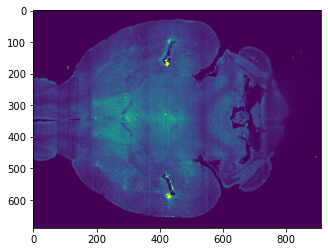

In [23]:
fig=plt.figure()
ax=fig.add_subplot()
z_plane = ws.source('resampled')[:,:,400]
ax.imshow(z_plane,vmin=0,vmax=200)

Looks good. One thing I thought of is I might want to resample to larger than atlas dimensions. This is what is done in brainpipe.

## Resampling - autofluorescence

In [17]:
  resample_parameter_auto = {
    "source_resolution" : (1.8,1.8,2.0),
    "sink_resolution"   : (15.,15.,10.),
    "processes" : None,
    "verbose" : True,
    };

res.resample(ws.filename('autofluorescence'),
             sink=ws.filename('resampled', postfix='autofluorescence'),
             **resample_parameter_auto)


Process     0: Resampling: resampling axes (0, 1), slice (0,) / 3586
Process     1: Resampling: resampling axes (0, 1), slice (1,) / 3586
Process     2: Resampling: resampling axes (0, 1), slice (2,) / 3586
Process     3: Resampling: resampling axes (0, 1), slice (3,) / 3586
Process     4: Resampling: resampling axes (0, 1), slice (4,) / 3586Process     5: Resampling: resampling axes (0, 1), slice (5,) / 3586Process     6: Resampling: resampling axes (0, 1), slice (6,) / 3586


Process     8: Resampling: resampling axes (0, 1), slice (8,) / 3586Process    11: Resampling: resampling axes (0, 1), slice (11,) / 3586Process     9: Resampling: resampling axes (0, 1), slice (9,) / 3586Process    13: Resampling: resampling axes (0, 1), slice (13,) / 3586Process    12: Resampling: resampling axes (0, 1), slice (12,) / 3586Process    10: Resampling: resampling axes (0, 1), slice (10,) / 3586Process    14: Resampling: resampling axes (0, 1), slice (14,) / 3586






Process    23: Resampling: re

Process   234: Resampling: resampling axes (0, 1), slice (234,) / 3586Process   236: Resampling: resampling axes (0, 1), slice (236,) / 3586Process   232: Resampling: resampling axes (0, 1), slice (232,) / 3586Process   233: Resampling: resampling axes (0, 1), slice (233,) / 3586Process   231: Resampling: resampling axes (0, 1), slice (231,) / 3586



Process   238: Resampling: resampling axes (0, 1), slice (238,) / 3586
Process   240: Resampling: resampling axes (0, 1), slice (240,) / 3586
Process   241: Resampling: resampling axes (0, 1), slice (241,) / 3586
Process   235: Resampling: resampling axes (0, 1), slice (235,) / 3586Process   237: Resampling: resampling axes (0, 1), slice (237,) / 3586
Process   239: Resampling: resampling axes (0, 1), slice (239,) / 3586


Process   242: Resampling: resampling axes (0, 1), slice (242,) / 3586
Process   244: Resampling: resampling axes (0, 1), slice (244,) / 3586Process   245: Resampling: resampling axes (0, 1), slice (245,) / 3586
Process

Process   461: Resampling: resampling axes (0, 1), slice (461,) / 3586
Process   460: Resampling: resampling axes (0, 1), slice (460,) / 3586
Process   462: Resampling: resampling axes (0, 1), slice (462,) / 3586
Process   463: Resampling: resampling axes (0, 1), slice (463,) / 3586Process   464: Resampling: resampling axes (0, 1), slice (464,) / 3586

Process   466: Resampling: resampling axes (0, 1), slice (466,) / 3586Process   465: Resampling: resampling axes (0, 1), slice (465,) / 3586
Process   467: Resampling: resampling axes (0, 1), slice (467,) / 3586

Process   469: Resampling: resampling axes (0, 1), slice (469,) / 3586
Process   471: Resampling: resampling axes (0, 1), slice (471,) / 3586
Process   470: Resampling: resampling axes (0, 1), slice (470,) / 3586Process   468: Resampling: resampling axes (0, 1), slice (468,) / 3586

Process   472: Resampling: resampling axes (0, 1), slice (472,) / 3586Process   473: Resampling: resampling axes (0, 1), slice (473,) / 3586Process 

Process   687: Resampling: resampling axes (0, 1), slice (687,) / 3586
Process   691: Resampling: resampling axes (0, 1), slice (691,) / 3586Process   692: Resampling: resampling axes (0, 1), slice (692,) / 3586
Process   694: Resampling: resampling axes (0, 1), slice (694,) / 3586

Process   693: Resampling: resampling axes (0, 1), slice (693,) / 3586
Process   695: Resampling: resampling axes (0, 1), slice (695,) / 3586
Process   697: Resampling: resampling axes (0, 1), slice (697,) / 3586
Process   698: Resampling: resampling axes (0, 1), slice (698,) / 3586Process   699: Resampling: resampling axes (0, 1), slice (699,) / 3586

Process   700: Resampling: resampling axes (0, 1), slice (700,) / 3586Process   696: Resampling: resampling axes (0, 1), slice (696,) / 3586

Process   701: Resampling: resampling axes (0, 1), slice (701,) / 3586Process   702: Resampling: resampling axes (0, 1), slice (702,) / 3586

Process   703: Resampling: resampling axes (0, 1), slice (703,) / 3586Process

Process   920: Resampling: resampling axes (0, 1), slice (920,) / 3586
Process   921: Resampling: resampling axes (0, 1), slice (921,) / 3586Process   922: Resampling: resampling axes (0, 1), slice (922,) / 3586

Process   924: Resampling: resampling axes (0, 1), slice (924,) / 3586
Process   923: Resampling: resampling axes (0, 1), slice (923,) / 3586

Process   925: Resampling: resampling axes (0, 1), slice (925,) / 3586Process   926: Resampling: resampling axes (0, 1), slice (926,) / 3586

Process   927: Resampling: resampling axes (0, 1), slice (927,) / 3586Process   928: Resampling: resampling axes (0, 1), slice (928,) / 3586
Process   929: Resampling: resampling axes (0, 1), slice (929,) / 3586
Process   931: Resampling: resampling axes (0, 1), slice (931,) / 3586Process   930: Resampling: resampling axes (0, 1), slice (930,) / 3586
Process   932: Resampling: resampling axes (0, 1), slice (932,) / 3586Process   933: Resampling: resampling axes (0, 1), slice (933,) / 3586

Process

Process  1148: Resampling: resampling axes (0, 1), slice (1148,) / 3586

Process  1147: Resampling: resampling axes (0, 1), slice (1147,) / 3586
Process  1150: Resampling: resampling axes (0, 1), slice (1150,) / 3586
Process  1151: Resampling: resampling axes (0, 1), slice (1151,) / 3586
Process  1149: Resampling: resampling axes (0, 1), slice (1149,) / 3586
Process  1153: Resampling: resampling axes (0, 1), slice (1153,) / 3586
Process  1154: Resampling: resampling axes (0, 1), slice (1154,) / 3586Process  1152: Resampling: resampling axes (0, 1), slice (1152,) / 3586

Process  1156: Resampling: resampling axes (0, 1), slice (1156,) / 3586Process  1155: Resampling: resampling axes (0, 1), slice (1155,) / 3586

Process  1157: Resampling: resampling axes (0, 1), slice (1157,) / 3586
Process  1158: Resampling: resampling axes (0, 1), slice (1158,) / 3586
Process  1159: Resampling: resampling axes (0, 1), slice (1159,) / 3586
Process  1161: Resampling: resampling axes (0, 1), slice (1161,

Process  1373: Resampling: resampling axes (0, 1), slice (1373,) / 3586
Process  1370: Resampling: resampling axes (0, 1), slice (1370,) / 3586
Process  1374: Resampling: resampling axes (0, 1), slice (1374,) / 3586

Process  1375: Resampling: resampling axes (0, 1), slice (1375,) / 3586Process  1376: Resampling: resampling axes (0, 1), slice (1376,) / 3586
Process  1377: Resampling: resampling axes (0, 1), slice (1377,) / 3586
Process  1378: Resampling: resampling axes (0, 1), slice (1378,) / 3586
Process  1380: Resampling: resampling axes (0, 1), slice (1380,) / 3586Process  1379: Resampling: resampling axes (0, 1), slice (1379,) / 3586
Process  1381: Resampling: resampling axes (0, 1), slice (1381,) / 3586


Process  1383: Resampling: resampling axes (0, 1), slice (1383,) / 3586Process  1382: Resampling: resampling axes (0, 1), slice (1382,) / 3586
Process  1386: Resampling: resampling axes (0, 1), slice (1386,) / 3586
Process  1384: Resampling: resampling axes (0, 1), slice (1384,)

Process  1598: Resampling: resampling axes (0, 1), slice (1598,) / 3586

Process  1599: Resampling: resampling axes (0, 1), slice (1599,) / 3586
Process  1600: Resampling: resampling axes (0, 1), slice (1600,) / 3586Process  1601: Resampling: resampling axes (0, 1), slice (1601,) / 3586

Process  1602: Resampling: resampling axes (0, 1), slice (1602,) / 3586
Process  1603: Resampling: resampling axes (0, 1), slice (1603,) / 3586Process  1604: Resampling: resampling axes (0, 1), slice (1604,) / 3586

Process  1605: Resampling: resampling axes (0, 1), slice (1605,) / 3586
Process  1606: Resampling: resampling axes (0, 1), slice (1606,) / 3586
Process  1607: Resampling: resampling axes (0, 1), slice (1607,) / 3586
Process  1608: Resampling: resampling axes (0, 1), slice (1608,) / 3586
Process  1610: Resampling: resampling axes (0, 1), slice (1610,) / 3586
Process  1611: Resampling: resampling axes (0, 1), slice (1611,) / 3586Process  1609: Resampling: resampling axes (0, 1), slice (1609,)

Process  1824: Resampling: resampling axes (0, 1), slice (1824,) / 3586
Process  1825: Resampling: resampling axes (0, 1), slice (1825,) / 3586

Process  1826: Resampling: resampling axes (0, 1), slice (1826,) / 3586
Process  1827: Resampling: resampling axes (0, 1), slice (1827,) / 3586
Process  1829: Resampling: resampling axes (0, 1), slice (1829,) / 3586
Process  1830: Resampling: resampling axes (0, 1), slice (1830,) / 3586

Process  1828: Resampling: resampling axes (0, 1), slice (1828,) / 3586Process  1832: Resampling: resampling axes (0, 1), slice (1832,) / 3586Process  1831: Resampling: resampling axes (0, 1), slice (1831,) / 3586


Process  1833: Resampling: resampling axes (0, 1), slice (1833,) / 3586Process  1834: Resampling: resampling axes (0, 1), slice (1834,) / 3586
Process  1835: Resampling: resampling axes (0, 1), slice (1835,) / 3586Process  1836: Resampling: resampling axes (0, 1), slice (1836,) / 3586


Process  1837: Resampling: resampling axes (0, 1), slice (1837

Process  2048: Resampling: resampling axes (0, 1), slice (2048,) / 3586Process  2050: Resampling: resampling axes (0, 1), slice (2050,) / 3586Process  2049: Resampling: resampling axes (0, 1), slice (2049,) / 3586


Process  2051: Resampling: resampling axes (0, 1), slice (2051,) / 3586
Process  2053: Resampling: resampling axes (0, 1), slice (2053,) / 3586Process  2052: Resampling: resampling axes (0, 1), slice (2052,) / 3586

Process  2054: Resampling: resampling axes (0, 1), slice (2054,) / 3586
Process  2055: Resampling: resampling axes (0, 1), slice (2055,) / 3586
Process  2056: Resampling: resampling axes (0, 1), slice (2056,) / 3586
Process  2057: Resampling: resampling axes (0, 1), slice (2057,) / 3586
Process  2059: Resampling: resampling axes (0, 1), slice (2059,) / 3586
Process  2060: Resampling: resampling axes (0, 1), slice (2060,) / 3586
Process  2061: Resampling: resampling axes (0, 1), slice (2061,) / 3586Process  2062: Resampling: resampling axes (0, 1), slice (2062,) 

Process  2273: Resampling: resampling axes (0, 1), slice (2273,) / 3586
Process  2275: Resampling: resampling axes (0, 1), slice (2275,) / 3586
Process  2274: Resampling: resampling axes (0, 1), slice (2274,) / 3586
Process  2276: Resampling: resampling axes (0, 1), slice (2276,) / 3586
Process  2278: Resampling: resampling axes (0, 1), slice (2278,) / 3586Process  2277: Resampling: resampling axes (0, 1), slice (2277,) / 3586
Process  2280: Resampling: resampling axes (0, 1), slice (2280,) / 3586
Process  2281: Resampling: resampling axes (0, 1), slice (2281,) / 3586

Process  2279: Resampling: resampling axes (0, 1), slice (2279,) / 3586
Process  2284: Resampling: resampling axes (0, 1), slice (2284,) / 3586
Process  2283: Resampling: resampling axes (0, 1), slice (2283,) / 3586
Process  2285: Resampling: resampling axes (0, 1), slice (2285,) / 3586
Process  2282: Resampling: resampling axes (0, 1), slice (2282,) / 3586
Process  2286: Resampling: resampling axes (0, 1), slice (2286,)

Process  2498: Resampling: resampling axes (0, 1), slice (2498,) / 3586Process  2496: Resampling: resampling axes (0, 1), slice (2496,) / 3586

Process  2500: Resampling: resampling axes (0, 1), slice (2500,) / 3586

Process  2503: Resampling: resampling axes (0, 1), slice (2503,) / 3586
Process  2499: Resampling: resampling axes (0, 1), slice (2499,) / 3586
Process  2501: Resampling: resampling axes (0, 1), slice (2501,) / 3586Process  2502: Resampling: resampling axes (0, 1), slice (2502,) / 3586Process  2504: Resampling: resampling axes (0, 1), slice (2504,) / 3586
Process  2505: Resampling: resampling axes (0, 1), slice (2505,) / 3586Process  2506: Resampling: resampling axes (0, 1), slice (2506,) / 3586Process  2507: Resampling: resampling axes (0, 1), slice (2507,) / 3586




Process  2509: Resampling: resampling axes (0, 1), slice (2509,) / 3586
Process  2511: Resampling: resampling axes (0, 1), slice (2511,) / 3586Process  2510: Resampling: resampling axes (0, 1), slice (2510,)

Process  2723: Resampling: resampling axes (0, 1), slice (2723,) / 3586
Process  2725: Resampling: resampling axes (0, 1), slice (2725,) / 3586Process  2724: Resampling: resampling axes (0, 1), slice (2724,) / 3586Process  2726: Resampling: resampling axes (0, 1), slice (2726,) / 3586

Process  2728: Resampling: resampling axes (0, 1), slice (2728,) / 3586
Process  2729: Resampling: resampling axes (0, 1), slice (2729,) / 3586
Process  2730: Resampling: resampling axes (0, 1), slice (2730,) / 3586Process  2731: Resampling: resampling axes (0, 1), slice (2731,) / 3586

Process  2732: Resampling: resampling axes (0, 1), slice (2732,) / 3586Process  2727: Resampling: resampling axes (0, 1), slice (2727,) / 3586
Process  2733: Resampling: resampling axes (0, 1), slice (2733,) / 3586Process  2735: Resampling: resampling axes (0, 1), slice (2735,) / 3586

Process  2734: Resampling: resampling axes (0, 1), slice (2734,) / 3586


Process  2736: Resampling: resampling axes (0, 1), slice (2736,)

Process  2948: Resampling: resampling axes (0, 1), slice (2948,) / 3586Process  2949: Resampling: resampling axes (0, 1), slice (2949,) / 3586

Process  2950: Resampling: resampling axes (0, 1), slice (2950,) / 3586
Process  2951: Resampling: resampling axes (0, 1), slice (2951,) / 3586
Process  2952: Resampling: resampling axes (0, 1), slice (2952,) / 3586Process  2953: Resampling: resampling axes (0, 1), slice (2953,) / 3586
Process  2954: Resampling: resampling axes (0, 1), slice (2954,) / 3586
Process  2955: Resampling: resampling axes (0, 1), slice (2955,) / 3586
Process  2957: Resampling: resampling axes (0, 1), slice (2957,) / 3586

Process  2956: Resampling: resampling axes (0, 1), slice (2956,) / 3586Process  2958: Resampling: resampling axes (0, 1), slice (2958,) / 3586
Process  2960: Resampling: resampling axes (0, 1), slice (2960,) / 3586Process  2961: Resampling: resampling axes (0, 1), slice (2961,) / 3586

Process  2962: Resampling: resampling axes (0, 1), slice (2962,) 

Process  3174: Resampling: resampling axes (0, 1), slice (3174,) / 3586Process  3176: Resampling: resampling axes (0, 1), slice (3176,) / 3586Process  3175: Resampling: resampling axes (0, 1), slice (3175,) / 3586
Process  3178: Resampling: resampling axes (0, 1), slice (3178,) / 3586Process  3181: Resampling: resampling axes (0, 1), slice (3181,) / 3586
Process  3180: Resampling: resampling axes (0, 1), slice (3180,) / 3586
Process  3179: Resampling: resampling axes (0, 1), slice (3179,) / 3586

Process  3173: Resampling: resampling axes (0, 1), slice (3173,) / 3586
Process  3177: Resampling: resampling axes (0, 1), slice (3177,) / 3586
Process  3182: Resampling: resampling axes (0, 1), slice (3182,) / 3586

Process  3183: Resampling: resampling axes (0, 1), slice (3183,) / 3586Process  3184: Resampling: resampling axes (0, 1), slice (3184,) / 3586
Process  3185: Resampling: resampling axes (0, 1), slice (3185,) / 3586Process  3186: Resampling: resampling axes (0, 1), slice (3186,) / 

Process  3399: Resampling: resampling axes (0, 1), slice (3399,) / 3586
Process  3398: Resampling: resampling axes (0, 1), slice (3398,) / 3586Process  3401: Resampling: resampling axes (0, 1), slice (3401,) / 3586
Process  3403: Resampling: resampling axes (0, 1), slice (3403,) / 3586



Process  3404: Resampling: resampling axes (0, 1), slice (3404,) / 3586Process  3405: Resampling: resampling axes (0, 1), slice (3405,) / 3586Process  3406: Resampling: resampling axes (0, 1), slice (3406,) / 3586


Process  3402: Resampling: resampling axes (0, 1), slice (3402,) / 3586

Process  3407: Resampling: resampling axes (0, 1), slice (3407,) / 3586Process  3408: Resampling: resampling axes (0, 1), slice (3408,) / 3586

Process  3411: Resampling: resampling axes (0, 1), slice (3411,) / 3586Process  3410: Resampling: resampling axes (0, 1), slice (3410,) / 3586Process  3412: Resampling: resampling axes (0, 1), slice (3412,) / 3586
Process  3413: Resampling: resampling axes (0, 1), slice (3413,

Process    31: Resampling: resampling axes (0, 2), slice (31,) / 906

Process    34: Resampling: resampling axes (0, 2), slice (34,) / 906

Process    33: Resampling: resampling axes (0, 2), slice (33,) / 906



Process    36: Resampling: resampling axes (0, 2), slice (36,) / 906
Process    44: Resampling: resampling axes (0, 2), slice (44,) / 906
Process    45: Resampling: resampling axes (0, 2), slice (45,) / 906
Process    46: Resampling: resampling axes (0, 2), slice (46,) / 906
Process    47: Resampling: resampling axes (0, 2), slice (47,) / 906
Process    48: Resampling: resampling axes (0, 2), slice (48,) / 906
Process    49: Resampling: resampling axes (0, 2), slice (49,) / 906
Process    50: Resampling: resampling axes (0, 2), slice (50,) / 906
Process    51: Resampling: resampling axes (0, 2), slice (51,) / 906
Process    52: Resampling: resampling axes (0, 2), slice (52,) / 906
Process    53: Resampling: resampling axes (0, 2), slice (53,) / 906
Process    54: Resampling: re

Process   251: Resampling: resampling axes (0, 2), slice (251,) / 906Process   258: Resampling: resampling axes (0, 2), slice (258,) / 906























Process   275: Resampling: resampling axes (0, 2), slice (275,) / 906
Process   276: Resampling: resampling axes (0, 2), slice (276,) / 906
Process   277: Resampling: resampling axes (0, 2), slice (277,) / 906
Process   278: Resampling: resampling axes (0, 2), slice (278,) / 906
Process   279: Resampling: resampling axes (0, 2), slice (279,) / 906
Process   280: Resampling: resampling axes (0, 2), slice (280,) / 906
Process   281: Resampling: resampling axes (0, 2), slice (281,) / 906
Process   282: Resampling: resampling axes (0, 2), slice (282,) / 906
Process   283: Resampling: resampling axes (0, 2), slice (283,) / 906
Process   284: Resampling: resampling axes (0, 2), slice (284,) / 906
Process   285: Resampling: resampling axes (0, 2), slice (285,) / 906
Process   286: Resampling: resampling axes (0, 2), slice (286,) / 90

Process   506: Resampling: resampling axes (0, 2), slice (506,) / 906
Process   507: Resampling: resampling axes (0, 2), slice (507,) / 906
Process   508: Resampling: resampling axes (0, 2), slice (508,) / 906
Process   509: Resampling: resampling axes (0, 2), slice (509,) / 906
Process   510: Resampling: resampling axes (0, 2), slice (510,) / 906Process   511: Resampling: resampling axes (0, 2), slice (511,) / 906

Process   512: Resampling: resampling axes (0, 2), slice (512,) / 906
Process   513: Resampling: resampling axes (0, 2), slice (513,) / 906
Process   514: Resampling: resampling axes (0, 2), slice (514,) / 906
Process   515: Resampling: resampling axes (0, 2), slice (515,) / 906
Process   521: Resampling: resampling axes (0, 2), slice (521,) / 906Process   527: Resampling: resampling axes (0, 2), slice (527,) / 906Process   530: Resampling: resampling axes (0, 2), slice (530,) / 906Process   519: Resampling: resampling axes (0, 2), slice (519,) / 906Process   525: Resamplin

Process   742: Resampling: resampling axes (0, 2), slice (742,) / 906Process   743: Resampling: resampling axes (0, 2), slice (743,) / 906Process   739: Resampling: resampling axes (0, 2), slice (739,) / 906Process   744: Resampling: resampling axes (0, 2), slice (744,) / 906Process   741: Resampling: resampling axes (0, 2), slice (741,) / 906Process   746: Resampling: resampling axes (0, 2), slice (746,) / 906Process   745: Resampling: resampling axes (0, 2), slice (745,) / 906Process   738: Resampling: resampling axes (0, 2), slice (738,) / 906Process   747: Resampling: resampling axes (0, 2), slice (747,) / 906


Process   748: Resampling: resampling axes (0, 2), slice (748,) / 906Process   737: Resampling: resampling axes (0, 2), slice (737,) / 906

Process   740: Resampling: resampling axes (0, 2), slice (740,) / 906




Process   749: Resampling: resampling axes (0, 2), slice (749,) / 906
Process   750: Resampling: resampling axes (0, 2), slice (750,) / 906
Process   752: Resampl

Tif-Source(687, 906, 718)[uint16]{/mnt/bucket/labs/wang/ahoag/test_clearmap2/output/...ng_request_1/output/resampled_autofluorescence.tif}

Visualize the resampled autofluorescence channel

In [18]:
ws.source('resampled',postfix='autofluorescence')

Tif-Source(687, 906, 718)[uint16]{/mnt/bucket/labs/wang/ahoag/test_clearmap2/output/...ng_request_1/output/resampled_autofluorescence.tif}

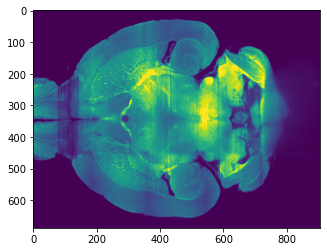

In [20]:
fig=plt.figure()
ax=fig.add_subplot()
z_plane = ws.source('resampled',postfix='autofluorescence')[:,:,400]
ax.imshow(z_plane,vmin=0,vmax=600)

Visualize cell channel resampled and auto channel resampled side by side

Text(0.5, 1.0, 'cell channel resampled')

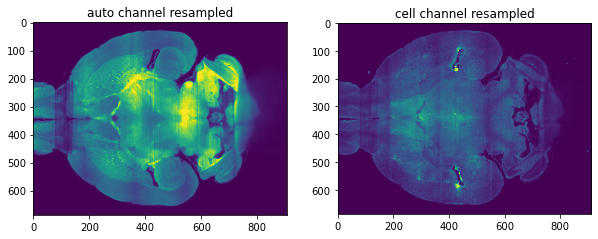

In [24]:
fig=plt.figure(figsize=(10,10))
ax_auto=fig.add_subplot(121)
z_plane_auto = ws.source('resampled',postfix='autofluorescence')[:,:,400]
ax_auto.imshow(z_plane_auto,vmin=0,vmax=600)
ax_auto.set_title("auto channel resampled")
ax_cell = fig.add_subplot(122)
z_plane_cell = ws.source('resampled')[:,:,400]
ax_cell.imshow(z_plane_cell,vmin=0,vmax=200)
ax_cell.set_title('cell channel resampled')

## Alignment - resampled cell channel to resampled autofluorescence

Let's look at both of the resampled channels side by side to make sure they are in the same orientation and everything

In [25]:
#alignment parameter files
align_channels_affine_file   = io.join(resources_directory, 'Alignment/align_affine.txt')
align_reference_affine_file  = io.join(resources_directory, 'Alignment/align_affine.txt')
align_reference_bspline_file = io.join(resources_directory, 'Alignment/align_bspline.txt')

In [5]:
ws.filename('resampled_to_auto') # this is the directory where the resulting resampled 
# cell channel will be aligned to the resampled autofluorescence channel 

'/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/elastix_resampled_to_auto'

In [33]:
# align the two channels
align_channels_parameter = {
    #moving and reference images
    "fixed_image" : ws.filename('resampled', postfix='autofluorescence'),
    "moving_image"  : ws.filename('resampled'),

    #elastix parameter files for alignment
    "affine_parameter_file"  : align_channels_affine_file,
    "bspline_parameter_file" : align_reference_bspline_file,

    #directory of the alignment result
    "result_directory" :  ws.filename('resampled_to_auto')
    };

elx.align(**align_channels_parameter);

Now check to make sure the resulting resampled, aligned cell channel is actually aligned to the resampled autofluorescence channel

In [34]:
resampled_aligned_to_auto_file = os.path.join(ws.filename('resampled_to_auto'),'result.1.mhd')
itkimage_resampled_aligned_to_auto = sitk.ReadImage(resampled_aligned_to_auto_file)

# Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
resampled_aligned_to_auto_vol = sitk.GetArrayFromImage(itkimage_resampled_aligned_to_auto)

In [35]:
resampled_aligned_to_auto_vol.shape

(718, 906, 687)

In [36]:
ws.source('resampled',postfix='autofluorescence')

Tif-Source(687, 906, 718)[uint16]{/mnt/bucket/labs/wang/ahoag/test_clearmap2/output/...ng_request_1/output/resampled_autofluorescence.tif}

Text(0.5, 1.0, 'cell channel resampled, algined to auto resampled')

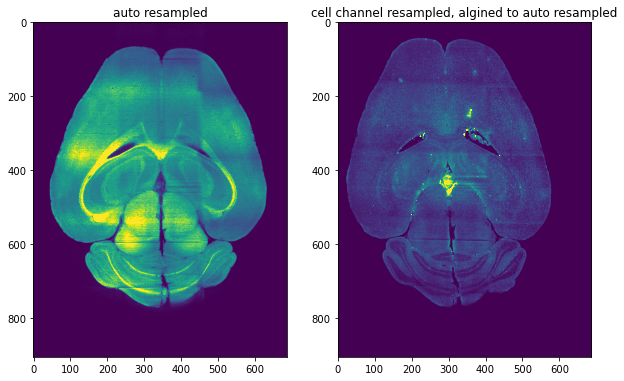

In [37]:
fig=plt.figure(figsize=(10,10))
ax_auto=fig.add_subplot(121)
z_plane_auto = ws.source('resampled',postfix='autofluorescence')[:,:,200]
z_plane_auto_fixxy = np.swapaxes(z_plane_auto,0,1)
ax_auto.imshow(z_plane_auto_fixxy,vmin=0,vmax=600)
ax_auto.set_title("auto resampled")
ax_aligned = fig.add_subplot(122)
z_plane_aligned = resampled_aligned_to_auto_vol[200]
ax_aligned.imshow(z_plane_aligned,vmin=0,vmax=200)
ax_aligned.set_title('cell channel resampled, aligned to auto resampled')

Still bad alignment. 

Text(0.5, 1.0, 'cell channel resampled, algined to auto resampled')

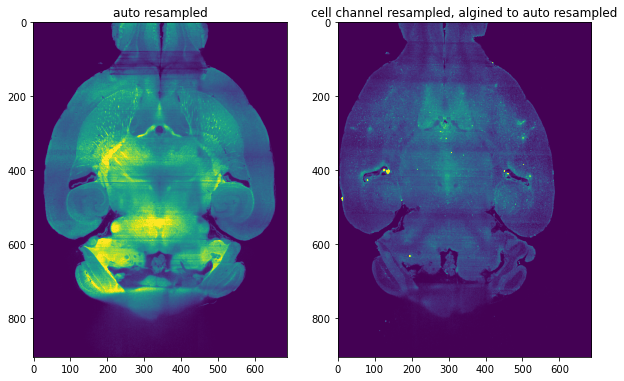

In [32]:
fig=plt.figure(figsize=(10,10))
ax_auto=fig.add_subplot(121)
z_plane_auto = ws.source('resampled',postfix='autofluorescence')[:,:,400]
z_plane_auto_fixxy = np.swapaxes(z_plane_auto,0,1)
ax_auto.imshow(z_plane_auto_fixxy,vmin=0,vmax=600)
ax_auto.set_title("auto resampled")
ax_aligned = fig.add_subplot(122)
z_plane_aligned = resampled_aligned_to_auto_vol[400]
ax_aligned.imshow(z_plane_aligned,vmin=0,vmax=200)
ax_aligned.set_title('cell channel resampled, algined to auto resampled')

It looks better than before but still off by a bit. The last thing I can think of is using the ch642 corrected planes that have the same number as the ch488 channel.  

In [20]:
resampled_aligned_to_auto_file = os.path.join(ws.filename('resampled_to_auto'),'result.0.mhd')
itkimage_resampled_aligned_to_auto = sitk.ReadImage(resampled_aligned_to_auto_file)

# Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
resampled_aligned_to_auto_vol = sitk.GetArrayFromImage(itkimage_resampled_aligned_to_auto)

Text(0.5, 1.0, 'cell channel resampled, algined to auto resampled')

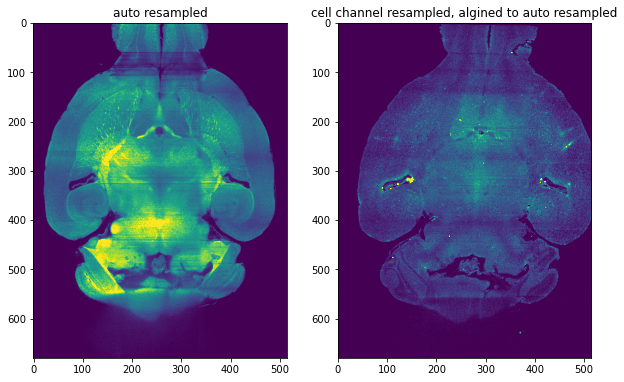

In [26]:
fig=plt.figure(figsize=(10,10))
ax_auto=fig.add_subplot(121)
z_plane_auto = ws.source('resampled',postfix='autofluorescence')[:,:,200]
z_plane_auto_fixxy = np.swapaxes(z_plane_auto,0,1)
ax_auto.imshow(z_plane_auto_fixxy,vmin=0,vmax=600)
ax_auto.set_title("auto resampled")
ax_aligned = fig.add_subplot(122)
z_plane_aligned = resampled_aligned_to_auto_vol[200]
ax_aligned.imshow(z_plane_aligned,vmin=0,vmax=200)
ax_aligned.set_title('cell channel resampled, algined to auto resampled')

Something went wrong when registering cell resampled -> auto resampled. Wondering if it was the fact that I didn't include the bspline. Let's try again using bspline. 

The other option is that I resampled my volumes down too much before alignment. Tom was using 1.3x the dimensions of the atlas, so I may want to try that if the bspline doesn't fix this. 

## Alignment -  autofluorescence to reference

In [21]:
reference_file = '/jukebox/LightSheetTransfer/atlas/sagittal_atlas_20um_iso.tif'

In [90]:
reference_file

'/jukebox/LightSheetTransfer/atlas/sagittal_atlas_20um_iso.tif'

In [124]:
reference_vol = tifffile.imread(reference_file)

In [126]:
ws.source('resampled', postfix='autofluorescence')

Tif-Source(515, 680, 359)[uint16]{/mnt/bucket/labs/wang/ahoag/test_clearmap2/output/...ng_request_1/output/resampled_autofluorescence.tif}

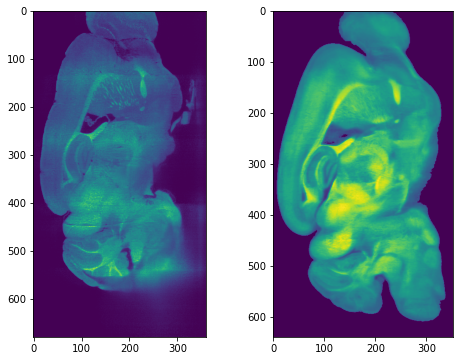

In [130]:
# First make sure orientation of atlas and resampled autofluorscence file are same:
fig = plt.figure(figsize=(8,6))
ax_auto=fig.add_subplot(121)
im_auto=ws.source('resampled', postfix='autofluorescence')[200]
ax_auto.imshow(im_auto)
ax_ref = fig.add_subplot(122)
ax_ref.imshow(reference_vol[200])

OK this looks fine. Are x and z swapped though because of clearmap's convention?

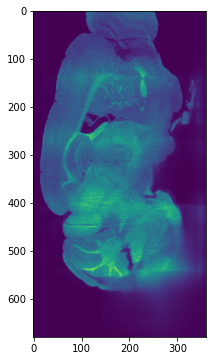

In [127]:
fig = plt.figure(figsize=(8,6))
ax_auto=fig.add_subplot(121)
im_auto=ws.source('resampled', postfix='autofluorescence')[370]
ax_auto.imshow(im)
# ax_ref = fig.add_subplot(122)
# ax_ref.imshow(reference_vol[200])

Yep, they are swapped! The first index of the source array is the X coordinate not the Z coordinate. So the real comparison is:

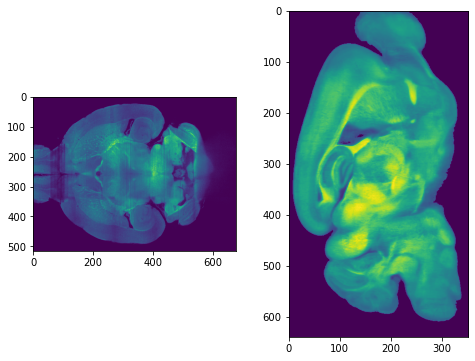

In [131]:
# 
fig = plt.figure(figsize=(8,6))
ax_auto=fig.add_subplot(121)
im_auto=ws.source('resampled', postfix='autofluorescence')[:,:,200]
ax_auto.imshow(im_auto)
ax_ref = fig.add_subplot(122)
ax_ref.imshow(reference_vol[200])

Dang, so I need to reorient the atlas before doing the registration so that z slices are horizontal cuts. 

In [132]:
reoriented_atlas = np.swapaxes(reference_vol,0,2)

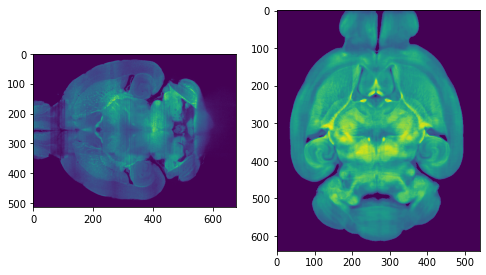

In [133]:
fig = plt.figure(figsize=(8,6))
ax_auto=fig.add_subplot(121)
im_auto=ws.source('resampled', postfix='autofluorescence')[:,:,200]
ax_auto.imshow(im_auto)
ax_ref = fig.add_subplot(122)
ax_ref.imshow(reoriented_atlas[200])

Hard to know if the x and y swap is a real thing or because of Clearmap's convention. Let's try to open the resampled file with sitk and compare. 

In [135]:
resampled_auto_file = ws.filename('resampled', postfix='autofluorescence')
itkimage = sitk.ReadImage(resampled_auto_file)

# Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
resampled_auto_vol = sitk.GetArrayFromImage(itkimage)

In [136]:
resampled_auto_vol.shape

(359, 680, 515)

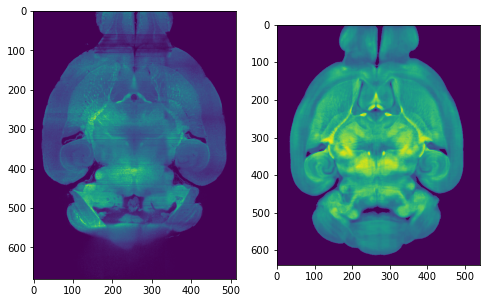

In [137]:
fig = plt.figure(figsize=(8,6))
ax_auto=fig.add_subplot(121)
im_auto=resampled_auto_vol[200]
ax_auto.imshow(im_auto)
ax_ref = fig.add_subplot(122)
ax_ref.imshow(reoriented_atlas[200])

OK so it does look correct. Let's make sure it's correct dorsal ventrally as well.

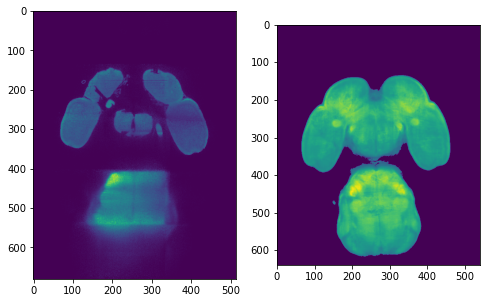

In [138]:
fig = plt.figure(figsize=(8,6))
ax_auto=fig.add_subplot(121)
im_auto=resampled_auto_vol[300]
ax_auto.imshow(im_auto)
ax_ref = fig.add_subplot(122)
ax_ref.imshow(reoriented_atlas[300])

Yeah looks good. OK let's try to realign once again using the reoriented reference volume!

In [147]:
savename_reoriented_reffile = reference_file.replace('.tif','_horizontal.tif')
tifffile.imsave(savename_reoriented_reffile,reoriented_atlas)

In [148]:
# align autofluorescence to reference
align_reference_parameter = {
    #moving and reference images
    "moving_image" : ws.filename('resampled', postfix='autofluorescence'),
    "fixed_image"  : savename_reoriented_reffile,

    #elastix parameter files for alignment
    "affine_parameter_file"  :  align_reference_affine_file,
    "bspline_parameter_file" :  align_reference_bspline_file,
    #directory of the alignment result
    "result_directory" :  ws.filename('auto_to_reference')
    };

elx.align(**align_reference_parameter);

## Align raw cells to atlas

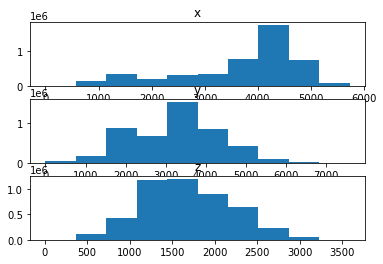

In [149]:
# Check distributions of x,y,z in raw cells
source = ws.source('cells', postfix='raw')
nx=3
ny=1
for i, name in enumerate(["x","y","z"]):
    plt.subplot(nx, ny, i+1)
    plt.hist(source[name]);
    plt.title(name)

In [150]:
source = ws.source('cells', postfix='raw')
coordinates_raw = np.hstack([source[c][:,None] for c in 'xyz']) 

In [151]:
z=1000
this_plane_coords = np.array([coord for coord in coordinates if coord[-1] == z])
xs = this_plane_coords[:,0]
ys = this_plane_coords[:,1]

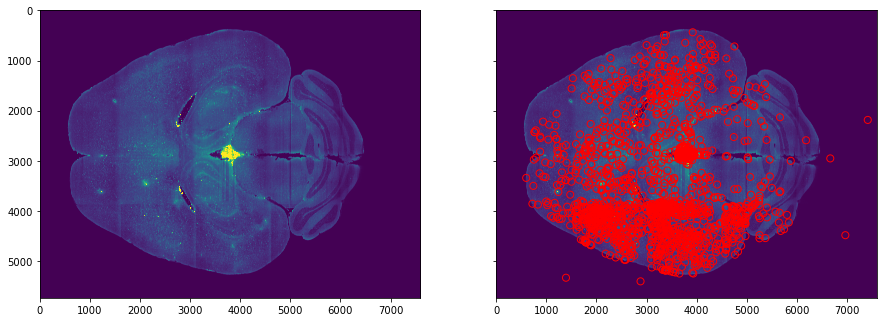

In [152]:
# Verify that raw cells are in the right locations and we understand the x,y,z layout of these clearmap files
fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
ax_tissue = axes[0]
stitched_z_plane = ws.source('stitched')[:,:,z] 
ax_tissue.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both=axes[1]
ax_both.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both.scatter(ys,xs,s=50,facecolors='none',edgecolors='r')
plt.show()

OK that looks good

Now let's verify that the alignment steps worked

In [153]:
auto_to_ref_file = os.path.join(ws.filename('auto_to_reference',),'result.0.mhd')
# auto_to_ref = tifffile.imread(auto_to_ref_file)
# Reads the image using SimpleITK
itkimage = sitk.ReadImage(auto_to_ref_file)

# Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
auto_to_ref = sitk.GetArrayFromImage(itkimage)

In [154]:
auto_to_ref.shape

(352, 640, 540)

OK good this is the atlas shape.

In [156]:
reoriented_atlas.shape

(352, 640, 540)

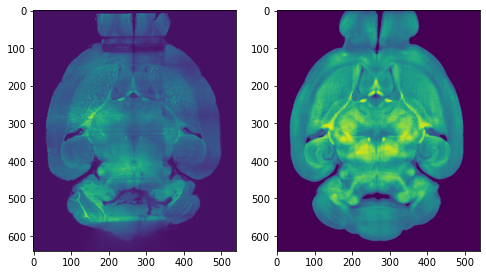

In [157]:
fig = plt.figure(figsize=(8,6))
ax_aligned=fig.add_subplot(121)
ax_aligned.imshow(auto_to_ref[200])
ax_ref = fig.add_subplot(122)
ax_ref.imshow(reoriented_atlas[200])

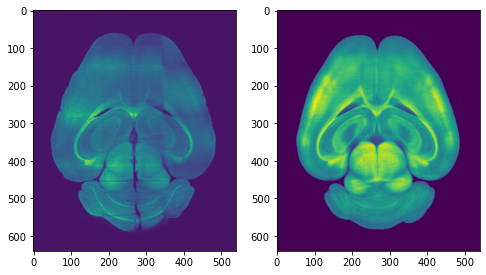

In [158]:
fig = plt.figure(figsize=(8,6))
ax_aligned=fig.add_subplot(121)
ax_aligned.imshow(auto_to_ref[100])
ax_ref = fig.add_subplot(122)
ax_ref.imshow(reoriented_atlas[100])

Looks good!

In [ ]:
fig = plt.figure(figsize=(8,6))
ax_aligned=fig.add_subplot(121)
ax_aligned.imshow(auto_to_ref[200])
ax_ref = fig.add_subplot(122)
ax_ref.imshow(reference_vol[200])

In [94]:
ws.filename('resampled', postfix='autofluorescence')

'/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/resampled_autofluorescence.tif'

In [95]:
ws.source('resampled', postfix='autofluorescence')

Tif-Source(515, 680, 359)[uint16]{/mnt/bucket/labs/wang/ahoag/test_clearmap2/output/...ng_request_1/output/resampled_autofluorescence.tif}

In [75]:
ws.info()

Workspace[CellMap]{/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output}
              raw: ch647_renamed/corrected/Z<Z,4>.tif {3589 files, ('Z',): (0,) -> (3588,)}
 autofluorescence: ch488_renamed/corrected/Z<Z,4>.tif {3586 files, ('Z',): (0,) -> (3585,)}
         stitched: stitched.npy
           layout: no file
       background: no file
        resampled: resampled.tif
                   resampled_autofluorescence.tif
resampled_to_auto: no file
auto_to_reference: no file
            cells: cells_raw.npy
                   cells_transformed_to_atlas.npy
          density: no file



In [220]:
#%% Cell alignment

source = ws.source('cells', postfix='raw')

def transformation(coordinates):
    coordinates = res.resample_points(
                  coordinates, sink=None, orientation=None,
                  source_shape=io.shape(ws.filename('stitched')),
                  sink_shape=io.shape(ws.filename('resampled')));

    coordinates = elx.transform_points(
                  coordinates, sink=None,
                  transform_directory=ws.filename('resampled_to_auto'),
                  binary=True, indices=False);

    coordinates = elx.transform_points(
                  coordinates, sink=None,
                  transform_directory=ws.filename('auto_to_reference'),
                  binary=True, indices=False);

    return coordinates;


coordinates = np.array([source[c] for c in 'xyz']).T;

coordinates_transformed = transformation(coordinates);

/jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build/bin/transformix -def /tmp/elastix_input.bin -out /tmp/elastix_output -tp /jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/elastix_resampled_to_auto/TransformParameters.0.txt
/jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build/bin/transformix -def /tmp/elastix_input.bin -out /tmp/elastix_output -tp /jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/elastix_auto_to_reference/TransformParameters.1.txt


In [224]:
source = ws.source('cells', postfix='raw')

raw_coordinates = np.array([source[c] for c in 'xyz']).T;

Text(0.5, 0.98, 'Distribution of cell centers in raw cells')

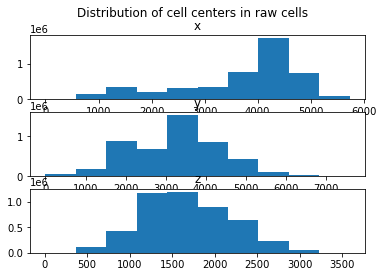

In [225]:
# Check raw cell distributions
nx=3
ny=1
for i, name in enumerate(["x","y","z"]):
    plt.subplot(nx, ny, i+1)
    plt.hist(ws.source('cells',postfix='raw')[name]);
    plt.title(name)
plt.suptitle("Distribution of cell centers in raw cells")

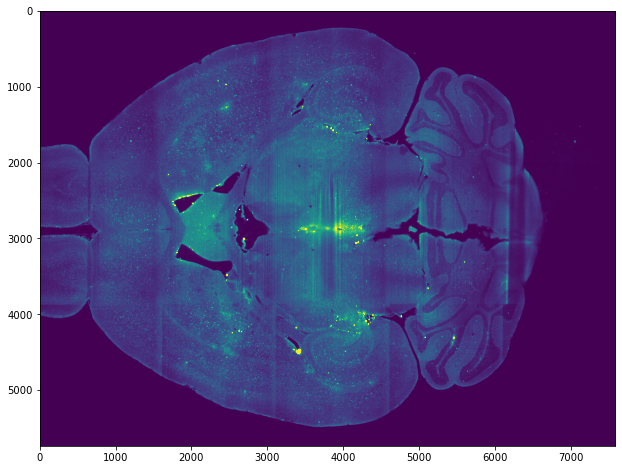

In [223]:
# Check that this is consistent with what we see in the raw data
fig = plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)
stitched_z_plane = ws.source('stitched')[:,:,1500] 
ax.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')

There is a peak at x~4000, y~3000 consistent with the histograms and this z plane. 

In [226]:
resampled_coordinates = res.resample_points(
                  raw_coordinates, sink=None, orientation=None,
                  source_shape=io.shape(ws.filename('stitched')),
                  sink_shape=io.shape(ws.filename('resampled')));

In [227]:
resampled_coordinates

array([[323.95901639, 409.84141201,   1.00027863],
       [177.98360656,   6.30663857,   6.00167177],
       [234.42622951, 306.8630137 ,   8.9024798 ],
       ...,
       [146.87704918, 204.87565859, 358.89997214],
       [147.77868852, 205.95679663, 358.89997214],
       [208.27868852, 530.83877766, 358.89997214]])

In [228]:
resampled_coordinates[:,0]

array([323.95901639, 177.98360656, 234.42622951, ..., 146.87704918,
       147.77868852, 208.27868852])

Text(0.5, 0.98, 'Distribution of cell centers in resampled cells')

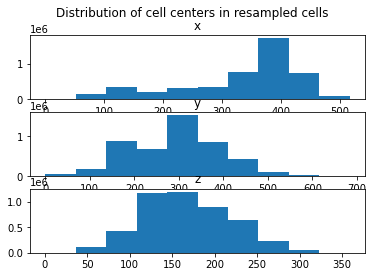

In [229]:
# Check resampled distributions
nx=3
ny=1
for i, name in enumerate(["x","y","z"]):
    plt.subplot(nx, ny, i+1)
    cellcoords = resampled_coordinates[:,i]
    plt.hist(cellcoords);
    plt.title(name)
plt.suptitle("Distribution of cell centers in resampled cells")

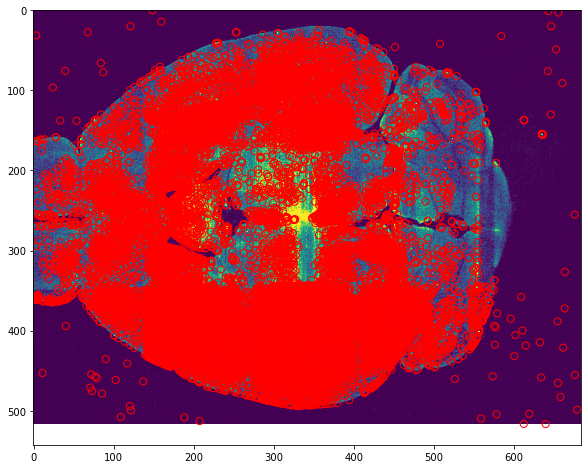

In [251]:
# Check that this is consistent with what we see in the resampled data
fig = plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)
z=150
resampled_z_plane = ws.source('resampled')[:,:,z]
ax.imshow(resampled_z_plane,cmap='viridis',vmin=0,vmax=100)
this_plane_coords_resampled = np.array([coord for coord in resampled_coordinates if int(coord[-1]) == z])
xs = this_plane_coords_resampled[:,0]
ys = this_plane_coords_resampled[:,1]
ax.scatter(ys,xs,s=50,facecolors='none',edgecolors='r')

This is also consistent with the histograms and the plot looks good.

In [232]:
resampled_aligned_to_auto_coordinates = elx.transform_points(
                  resampled_coordinates, sink=None,
                  transform_directory=ws.filename('resampled_to_auto'),
                  binary=True, indices=False);

/jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build/bin/transformix -def /tmp/elastix_input.bin -out /tmp/elastix_output -tp /jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/elastix_resampled_to_auto/TransformParameters.0.txt


In [233]:
resampled_aligned_to_auto_coordinates

array([[279.90010324, 408.09349554,   0.65458882],
       [114.31045924,   5.38050214,  12.91339366],
       [187.74328866, 306.13102325,   7.91432826],
       ...,
       [135.74402382, 203.13580077, 362.87181452],
       [136.6836741 , 204.20640853, 362.877995  ],
       [215.21512063, 529.32479353, 354.26255092]])

Text(0.5, 0.98, 'Distribution of cell centers in resampled_aligned_to_auto cells')

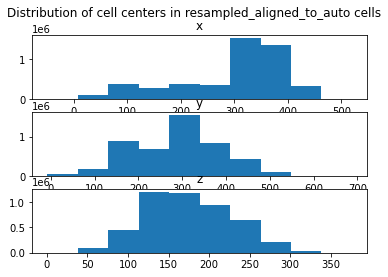

In [234]:
# Check resampled distributions
nx=3
ny=1
for i, name in enumerate(["x","y","z"]):
    plt.subplot(nx, ny, i+1)
    cellcoords = resampled_aligned_to_auto_coordinates[:,i]
    plt.hist(cellcoords);
    plt.title(name)
plt.suptitle("Distribution of cell centers in resampled_aligned_to_auto cells")

In [239]:
resampled_to_auto_file = os.path.join(ws.filename('resampled_to_auto'),'result.0.mhd')
itkimage_resampled_to_auto = sitk.ReadImage(resampled_to_auto_file)

# Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
resampled_to_auto_vol = sitk.GetArrayFromImage(itkimage_resampled_to_auto)

In [240]:
resampled_to_auto_vol.shape

(359, 680, 515)

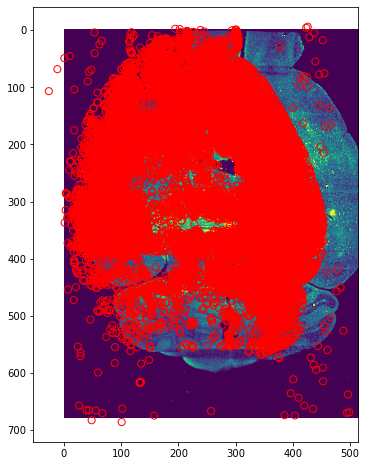

In [256]:
# Check that this is consistent with what we see in the resampled data
fig = plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)
z=150
resampled_to_auto_z_plane = resampled_to_auto_vol[z]
ax.imshow(resampled_to_auto_z_plane,cmap='viridis',vmin=0,vmax=100)
# Check that this is consistent with what we see in the resampled data

this_plane_coords_resampled_to_auto = np.array([coord for coord in resampled_aligned_to_auto_coordinates if int(coord[-1]) == z])
xs = this_plane_coords_resampled_to_auto[:,0]
ys = this_plane_coords_resampled_to_auto[:,1]
ax.scatter(xs,ys,s=50,facecolors='none',edgecolors='r')


Here is the problem! Something went wrong with the transformation between cell channel and autofluorescence channel.

Let's compare the resampled_to_auto volume with the resampled auto volume to make sure that transformation worked. 

In [264]:
ws.source('resampled',postfix='autofluorescence')

Tif-Source(515, 680, 359)[uint16]{/mnt/bucket/labs/wang/ahoag/test_clearmap2/output/...ng_request_1/output/resampled_autofluorescence.tif}

In [266]:
resampled_to_auto_vol.shape

(359, 680, 515)

So nominally they are the same shape. Let's check them

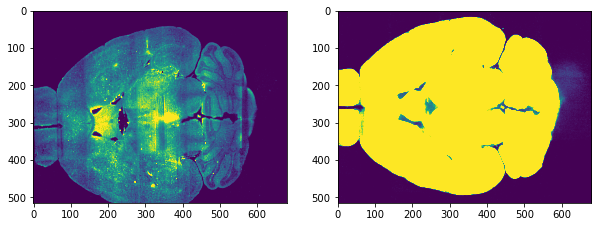

In [270]:
# Check that this is consistent with what we see in the resampled data
fig = plt.figure(figsize=(10,8))
ax_transformed=fig.add_subplot(121)
z=150
resampled_to_auto_z_plane = resampled_to_auto_vol[z]
resampled_to_auto_z_plane_swapped = np.swapaxes(resampled_to_auto_z_plane,0,1)
ax_transformed.imshow(resampled_to_auto_z_plane_swapped,cmap='viridis',vmin=0,vmax=100)
ax_auto_resampled=fig.add_subplot(122)
resampled_auto_z_plane = ws.source('resampled',postfix='autofluorescence')[:,:,z]
ax_auto_resampled.imshow(resampled_auto_z_plane,cmap='viridis',vmin=0,vmax=100)

They don't look aligned! This alignment must not have worked for some reason. 

Need to debug this alignment. Why did the cell channel get pushed to one side of the volume? Look at just the resampled cell channel to make sure it is still centered.

What happens if I just transform the cells using cell -> resample -> ref without the step of resample to auto?

In [258]:
resampled_aligned_to_atlas_coordinates = elx.transform_points(
                  resampled_coordinates, sink=None,
                  transform_directory=ws.filename('auto_to_reference'),
                  binary=True, indices=False)

/jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build/bin/transformix -def /tmp/elastix_input.bin -out /tmp/elastix_output -tp /jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/elastix_auto_to_reference/TransformParameters.1.txt


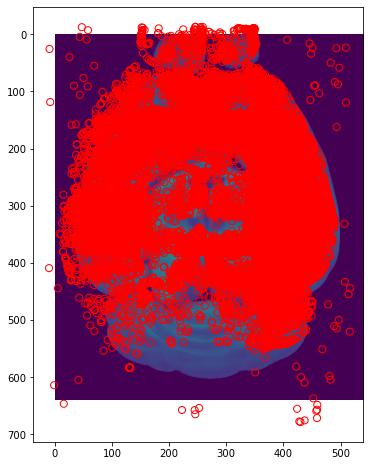

In [260]:
# Check that this is consistent with what we see in the resampled data
fig = plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)
z=150
reoriented_atlas_z_plane = reoriented_atlas[z]
ax.imshow(reoriented_atlas_z_plane,cmap='viridis',vmin=0,vmax=500)
# Check that this is consistent with what we see in the resampled data

this_plane_coords_resampled_aligned_to_atlas = np.array([coord for coord in resampled_aligned_to_atlas_coordinates if int(coord[-1]) == z])
xs = this_plane_coords_resampled_aligned_to_atlas[:,0]
ys = this_plane_coords_resampled_aligned_to_atlas[:,1]
ax.scatter(xs,ys,s=50,facecolors='none',edgecolors='r')

Looks pretty close, but it's not perfect. Need that extra small alignment.

(200.0, 600.0)

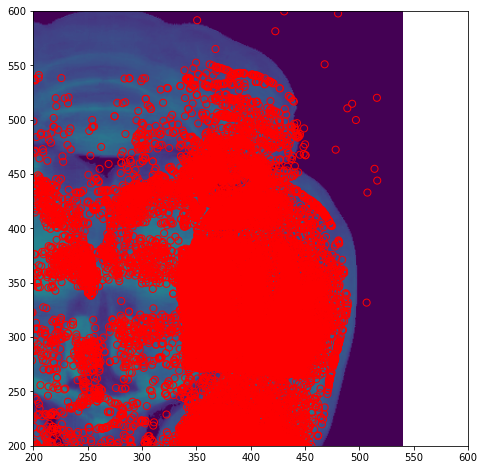

In [263]:
# Check that this is consistent with what we see in the resampled data
fig = plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)
z=150
reoriented_atlas_z_plane = reoriented_atlas[z]
ax.imshow(reoriented_atlas_z_plane,cmap='viridis',vmin=0,vmax=500)
# Check that this is consistent with what we see in the resampled data

this_plane_coords_resampled_aligned_to_atlas = np.array([coord for coord in resampled_aligned_to_atlas_coordinates if int(coord[-1]) == z])
xs = this_plane_coords_resampled_aligned_to_atlas[:,0]
ys = this_plane_coords_resampled_aligned_to_atlas[:,1]
ax.scatter(xs,ys,s=50,facecolors='none',edgecolors='r')
ax.set_xlim(200,600)
ax.set_ylim(200,600)

In [161]:
len(coordinates_transformed)

4743122

In [162]:
coordinates_transformed.shape

(4743122, 3)

In [163]:
# Save the transformed cells
header = ['x','y','z'];
dtypes = [int, int, int];

dt = {'names' : header, 'formats' : dtypes};
cells_out = np.zeros(len(coordinates_transformed), dtype=dt);
for i,h in enumerate(header):
    cells_out[h] = coordinates_transformed[:,i];

In [165]:
cells_out

array([(277, 324, 145), (167, 245, 144), (207, 301, 144), ...,
       (135, 279, 192), (136, 279, 192), (177, 340, 186)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('z', '<i8')])

In [166]:
# save the array as an npy file
savename = ws.filename('cells',postfix='transformed_to_atlas')
io.write(savename,cells_out)

'/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/cells_transformed_to_atlas.npy'

Text(0.5, 0.98, 'Test')

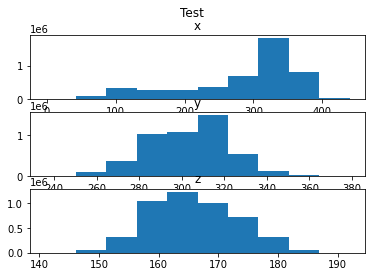

In [185]:
# Check distributions
nx=3
ny=1
for i, name in enumerate(["x","y","z"]):
    plt.subplot(nx, ny, i+1)
    plt.hist(ws.source('cells',postfix='transformed_to_atlas')[name]);
    plt.title(name)


In [171]:
source = ws.source('cells', postfix='transformed_to_atlas')
coordinates_aligned = np.hstack([source[c][:,None] for c in 'xyz']);
z=160
this_plane_coords = np.array([coord for coord in coordinates_aligned if coord[-1] == z])

In [172]:
this_plane_coords

array([[284, 263, 160],
       [280, 262, 160],
       [289, 265, 160],
       ...,
       [142, 365, 160],
       [135, 366, 160],
       [ 15, 363, 160]])

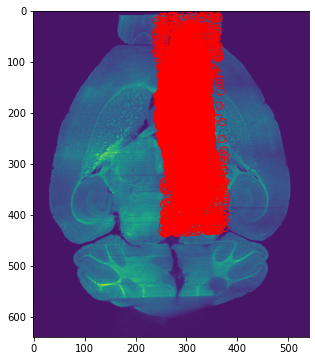

In [177]:
# Check whether this worked by visualizing cell volume registered to atlas
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.imshow(auto_to_ref[z])
xs = this_plane_coords[:,0]
ys = this_plane_coords[:,1]
ax.scatter(ys,xs,s=50,facecolors='none',edgecolors='r')

Still not working!!

So we know that the auto to atlas alignment worked because we checked that above. Need to check that the 